# Alternating Descent Conditional Gradient

1D Deconvolution using ADCG.

## Imports

In [1]:
import autograd.numpy as np
import autograd
import scipy.optimize
import pylab
from time import time
pylab.ion()

## Style

In [21]:
pylab.rcParams["lines.linestyle"] = ':'
pylab.rcParams["lines.linewidth"] = 5
pylab.rcParams["figure.figsize"] = (14, 3)

## Global variables

In [3]:
# Global variables
evaluation_points = np.linspace(0, 1, 50)
σ = 0.1

## Utility functions

In [4]:
# Gaussian
def ψ(θ):
    return np.exp(-((evaluation_points - θ) / σ) ** 2)

In [5]:
ψ(0.3).shape

(50,)

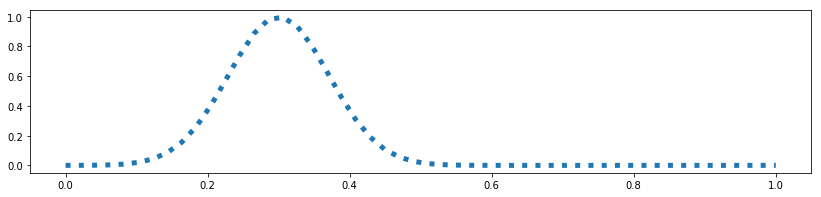

In [22]:
pylab.plot(evaluation_points, ψ(0.3));

In [7]:
# Weighted shifted gaussian functions
def Ψ(ws, θs):
    return np.sum(np.array([w*ψ(θ) for (w, θ) in zip(ws, θs)]), 0)

In [8]:
# Loss function
def l(ws, θs):
    return ((Ψ(ws, θs) - y) ** 2).sum()

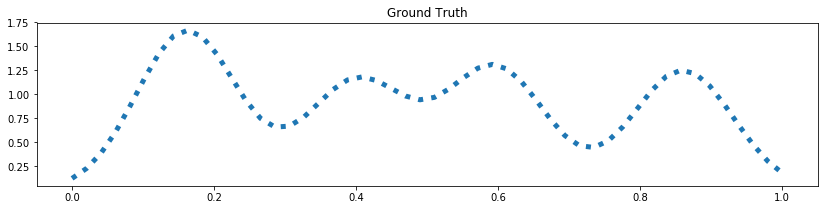

In [23]:
# Generate ground truth θs and weights ws
np.random.seed(69)
num_true_θs = np.random.randint(2, 5)
noise_level = 0.2
true_θs = np.random.rand(num_true_θs)
true_weights = np.random.rand(num_true_θs) + 1
y = (Ψ(true_weights, true_θs) 
     + noise_level * np.random.randn(len(evaluation_points)))
pylab.title("Ground Truth")
pylab.plot(evaluation_points, Ψ(true_weights, true_θs));

In [10]:
# ADCG first step "linear minimization oracle"
# We will grid θ to approximately solve the problem
grid_points = np.linspace(0, 1, 30)
grid_psi = np.stack([ψ(θ) for θ in grid_points])

def lmo(v):
    scores = grid_psi @ v
    return grid_points[scores.argmin()]

In [11]:
# ADCG second step "coordination optimization solving attempt"
def coordinate_descent(θs, iters=35, min_drop=1e-5):
    def min_ws():
        return scipy.optimize.nnls(np.stack([ψ(θ) for θ in θs]).T, y)[0]
    def min_θs():
        res = scipy.optimize.minimize(
                autograd.value_and_grad(lambda θs: l(ws, θs)),
                                        θs,
                                        jac=True,
                                        method='L-BFGS-B',
                                        bounds=[(0.0, 1.0)]*len(θs))
        return res["x"], res["fun"]
    
    old_f_val = np.inf
    for iter in range(iters):
        ws = min_ws()
        θs, f_val = min_θs()
        # check if loss is stationary
        if old_f_val - f_val < min_drop:
            break
        old_f_val = f_val
    return ws, θs

In [12]:
# ADCG second step "joint optimization solving attempt"
def local_search(θs):
    n = len(θs)
    # Stack weights and θs into a vector
    def f(x):
        return l(x[:n], x[n:])
    x_init = np.concatenate((np.zeros(n), θs))
    res = scipy.optimize.minimize(
            autograd.value_and_grad(f),
            x_init,
            jac=True,
            method="L-BFGS-B",
            bounds=([(0.0, None)]*n) + ([(0.0, 1.0)]*n))
    x = res["x"]
    ws = x[:n]
    θs = x[n:]
    return ws, θs

In [13]:
# TODO: Define ADCG
def ADCG(local_update, max_iters):
    θs = np.zeros(0)
    ws = np.zeros(0)
    output = np.zeros(len(evaluation_points))
    history = list()
    for iter in range(max_iters):
        residual = output - y
        loss = (residual**2).sum()
        #print(iter, loss)
        history.append((loss, θs, ws))
        θ = lmo(residual)
        ws, θs = local_update(np.append(θs, θ))
        output = Ψ(ws, θs)
    return history

In [14]:
# TODO: Define heuristic for selecting the number of true sources
def select_k(history):
    drop = np.array([history[i][0] - history[i+1][0]
                    for i in range(len(history) - 1)])
    k_hat = np.argmax(drop<0.1)
    return history[k_hat]

Ground truth results
---------------------
True loss: 2.608359358459474
True θs: [0.40157872 0.59582391 0.16174899 0.8603238 ]
True weights: [1.1430533  1.28132229 1.66428121 1.25002847]
---------------------

Coordinate descent results
---------------------
Coordinate descent loss: 2.074
Coordinate descent θs: [0.15096487 0.59086732 0.86430903 0.37707529]
Coordinate descent weights: [1.55972496 1.41077923 1.36876526 1.04324896]
Coordinate descent timing: 1.326s
---------------------

Joint optimization results
---------------------
Local search loss: 2.074
Local search θs: [0.15096361 0.59086983 0.86430868 0.37707719]
Local search weights: [1.55972826 1.41072462 1.36871783 1.04334755]
Local search timing: 1.976s
---------------------



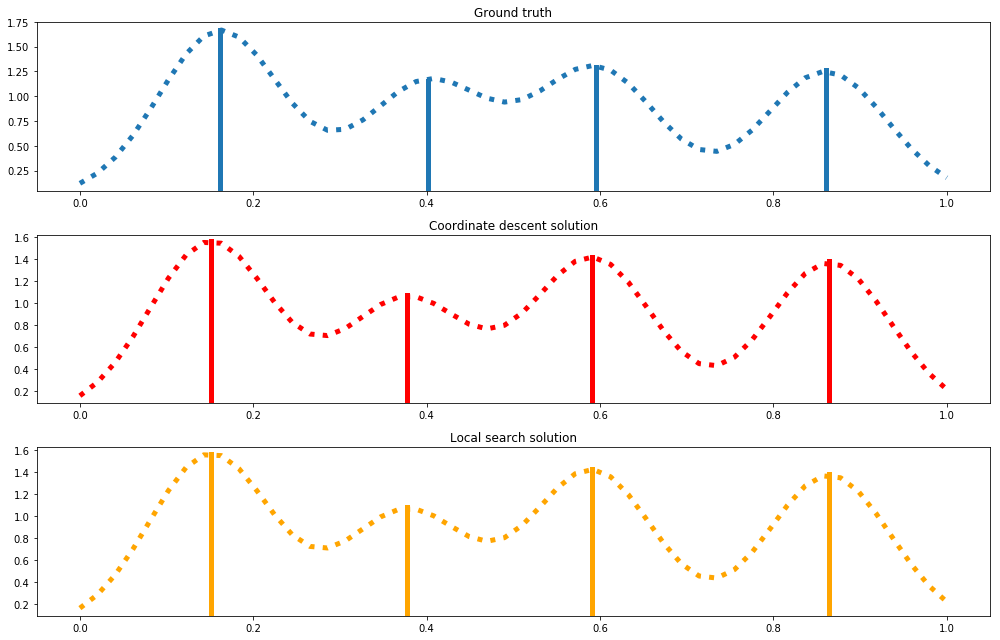

In [24]:
# Let's run it!
start = time()
res_cd = select_k(ADCG(coordinate_descent, 10))
time_cd = time() - start
start = time()
res_ls = select_k(ADCG(local_search, 10))
time_ls = time() - start
# True results
print("Ground truth results")
print("---------------------")
print("True loss:", l(true_weights, true_θs))
print("True θs:", true_θs)
print("True weights:", true_weights)
print("---------------------\n")
# Coordinate descent results
print("Coordinate descent results")
print("---------------------")
print("Coordinate descent loss: %.3f" % res_cd[0])
print("Coordinate descent θs:", res_cd[1])
print("Coordinate descent weights:", res_cd[2])
print("Coordinate descent timing: %.3fs" % time_cd)
print("---------------------\n")
# Joint optimization results
print("Joint optimization results")
print("---------------------")
print("Local search loss: %.3f" % res_ls[0])
print("Local search θs:", res_ls[1])
print("Local search weights:", res_ls[2])
print("Local search timing: %.3fs" % time_ls)
print("---------------------\n")
figure, axes = pylab.subplots(nrows=3, ncols=1, figsize=(14, 9))
axes[0].set_title("Ground truth")
axes[0].plot(evaluation_points, Ψ(true_weights, true_θs))
for i, θ in enumerate(true_θs):
    axes[0].axvline(x=θ, ymax=true_weights[i] / axes[0].get_ylim()[1],
                    linestyle="-")
axes[1].set_title("Coordinate descent solution")
axes[1].plot(evaluation_points, Ψ(res_cd[2], res_cd[1]), c="red")
for i, θ in enumerate(res_cd[1]):
    axes[1].axvline(x=θ, ymax=res_cd[2][i] / axes[1].get_ylim()[1],
                    linestyle="-", color="red")
axes[2].set_title("Local search solution")
axes[2].plot(evaluation_points, Ψ(res_ls[2], res_ls[1]), c="orange")
for i, θ in enumerate(res_ls[1]):
    axes[2].axvline(x=θ, ymax=res_ls[2][i] / axes[2].get_ylim()[1],
                    linestyle="-", color="orange")
pylab.tight_layout();

## TODO:
* Make the bumps closer together, or add more bumps. When does ADCG fail?
* Add more noise
* Change the number of evaluation points
* Change the size of the grid